In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda
from manapy.solvers.advec import AdvectionSolver

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, float_precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()

  
  return (domain, ne, u, v, w, P, running_conf)

In [2]:
dim = 3
mesh_file = "/home/aben-ham/Desktop/work/stage/manapy/mesh/3D/cube.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
domain, ne, u, v, w, P, conf = init(dim=dim, mesh_path=mesh_file)

S = AdvectionSolver(ne, vel=(u, v), conf=conf)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 4573
Number of Vertices: 1140
Local domain contruction ...


In [4]:
from numba import cuda

def create_var(v):
  if isinstance(v, (int, float, np.int32, np.float32, np.float64)):
    return (v, v)
  return (v, cuda.to_device(v))


host_rez_w, d_rez_w = create_var(S.var.convective)
host_w_c, d_w_c = create_var(S.var.cell)
host_w_ghost, d_w_ghost = create_var(S.var.ghost)
host_w_halo, d_w_halo = create_var(S.var.halo)
host_u_face, d_u_face = create_var(S.u.face)
host_v_face, d_v_face = create_var(S.v.face)
host_w_face, d_w_face = create_var(S.w.face,)
host_w_x, d_w_x = create_var(S.var.gradcellx)
host_w_y, d_w_y = create_var(S.var.gradcelly)
host_w_z, d_w_z = create_var(S.var.gradcellz)
host_wx_halo, d_wx_halo = create_var(S.var.gradhalocellx)
host_wy_halo, d_wy_halo = create_var(S.var.gradhalocelly)
host_wz_halo, d_wz_halo = create_var(S.var.gradhalocellz)
host_psi, d_psi = create_var(S.var.psi)
host_psi_halo, d_psi_halo = create_var(S.var.psihalo)
host_centerc, d_centerc = create_var(S.domain.cells.center)
host_centerf, d_centerf = create_var(S.domain.faces.center)
host_centerh, d_centerh = create_var(S.domain.halos.centvol)
host_centerg, d_centerg = create_var(S.domain.faces.ghostcenter)
host_cellidf, d_cellidf = create_var(S.domain.faces.cellid)
host_normalf, d_normalf = create_var(S.domain.faces.normal)
host_halofid, d_halofid = create_var(S.domain.faces.halofid)
host_name, d_name = create_var(S.domain.faces.name)
host_innerfaces, d_innerfaces = create_var(S.domain.innerfaces)
host_halofaces, d_halofaces = create_var(S.domain.halofaces)
host_boundaryfaces, d_boundaryfaces = create_var(S.domain.boundaryfaces)
host_periodicboundaryfaces, d_periodicboundaryfaces = create_var(S.domain.periodicboundaryfaces)
host_shift, d_shift = create_var(S.domain.cells.shift)
host_order, d_order = create_var(S.order)

### Cpu Function

In [5]:
#The original function from functions2d.py

from numpy import  int32, float32, float16, uint32
import numpy as np

def compute_upwind_flux(w_l:'float', w_r:'float', u_face:'float', v_face:'float', w_face:'float', 
                        normal:'float[:]', flux_w:'float[:]'):
     
    sol = 0.
    sign = u_face * normal[0] + v_face * normal[1] + w_face * normal[2]

    if sign >= 0:
        sol = w_l
    else:
        sol = w_r
    
    flux_w[0] = sign * sol

def explicitscheme_convective_3d(rez_w:'float[:]', w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]',
                                 u_face:'float[:]', v_face:'float[:]', w_face:'float[:]', 
                                 w_x:'float[:]', w_y:'float[:]', w_z:'float[:]', wx_halo:'float[:]', wy_halo:'float[:]', 
                                 wz_halo:'float[:]', psi:'float[:]', psi_halo:'float[:]', 
                                 centerc:'float[:,:]', centerf:'float[:,:]', centerh:'float[:,:]', centerg:'float[:,:]',
                                 cellidf:'int32[:,:]',  normalf:'float[:,:]', halofid:'int32[:]', name:'uint32[:]',
                                 innerfaces:'uint32[:]', halofaces:'uint32[:]', boundaryfaces:'uint32[:]', 
                                 periodicboundaryfaces:'uint32[:]', shift:'float[:,:]',  order:'int32'):
  
    
    center_left = np.zeros(3)
    center_right = np.zeros(3)
    r_l = np.zeros(3)
    r_r = np.zeros(3)
   
    normal = np.zeros(3)
    flux_w = np.zeros(1)    
   
    rez_w[:] = 0.

    for i in innerfaces:
        
        w_l = w_c[cellidf[i][0]]
        normal[:] = normalf[i][:]
        
        w_r = w_c[cellidf[i][1]]
        
        center_left[:] = centerc[cellidf[i][0]][:]
        center_right[:] = centerc[cellidf[i][1]][:]
        
        w_x_left = w_x[cellidf[i][0]]; w_x_right = w_x[cellidf[i][1]]
        w_y_left = w_y[cellidf[i][0]]; w_y_right = w_y[cellidf[i][1]]
        w_z_left = w_z[cellidf[i][0]]; w_z_right = w_z[cellidf[i][1]]
        
        psi_left  = psi[cellidf[i][0]];  psi_right  = psi[cellidf[i][1]]
        
        r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0]; 
        r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1]; 
        r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]; 
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  + (order - 1) * psi_right * (w_x_right* r_r[0]  + w_y_right* r_r[1] + w_z_right* r_r[2] )
        
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        
        rez_w[cellidf[i][0]]  -= flux_w[0]
        rez_w[cellidf[i][1]]  += flux_w[0]
    
    for i in periodicboundaryfaces:
        
        w_l = w_c[cellidf[i][0]]
        normal[:] = normalf[i][:]
        
        w_r = w_c[cellidf[i][1]]
        
        center_left[:] = centerc[cellidf[i][0]][:]
        center_right[:] = centerc[cellidf[i][1]][:]

        w_x_left = w_x[cellidf[i][0]]; w_x_right = w_x[cellidf[i][1]]
        w_y_left = w_y[cellidf[i][0]]; w_y_right = w_y[cellidf[i][1]]
        w_z_left = w_z[cellidf[i][0]]; w_z_right = w_z[cellidf[i][1]]
        
        psi_left  = psi[cellidf[i][0]];  psi_right  = psi[cellidf[i][1]]
           
        if name[i] == 11 or name[i] == 22:
            r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] - shift[cellidf[i][1]][0] 
            r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] 
            r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]
            
        if name[i] == 33 or name[i] == 44:
            r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] 
            r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] - shift[cellidf[i][1]][1] 
            r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]
        
        if name[i] == 55 or name[i] == 66:
            r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] 
            r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] 
            r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2] - shift[cellidf[i][1]][2] 
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  + (order - 1) * psi_right * (w_x_right* r_r[0]  + w_y_right* r_r[1] + w_z_right* r_r[2] )
        
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        rez_w[cellidf[i][0]]  -= flux_w[0]
                
    
    for i in halofaces:
        
        w_l = w_c[cellidf[i][0]]
        normal[:] = normalf[i][:]
        
        w_r  = w_halo[halofid[i]]
        
        center_left[:] = centerc[cellidf[i][0]][:]
        center_right[:] = centerh[halofid[i]][0:3]

        w_x_left = w_x[cellidf[i][0]];  w_x_right = wx_halo[halofid[i]]
        w_y_left = w_y[cellidf[i][0]];  w_y_right = wy_halo[halofid[i]]
        w_z_left = w_z[cellidf[i][0]];  w_z_right = wz_halo[halofid[i]]
        
        psi_left  = psi[cellidf[i][0]];   psi_right  = psi_halo[halofid[i]]
        
        r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] 
        r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] 
        r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  + (order - 1) * psi_right * (w_x_right* r_r[0]  + w_y_right* r_r[1] + w_z_right* r_r[2] )
        
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        rez_w[cellidf[i][0]]  -= flux_w[0]
   
    for i in boundaryfaces:
      
        w_l = w_c[cellidf[i][0]]
        normal[:] = normalf[i][:]
        
        w_r  = w_ghost[i]
        center_left[:] = centerc[cellidf[i][0]][:]
        
        w_x_left = w_x[cellidf[i][0]] 
        w_y_left = w_y[cellidf[i][0]] 
        w_z_left = w_z[cellidf[i][0]]
        
        psi_left  = psi[cellidf[i][0]];  
        
        r_l[0] = centerf[i][0] - center_left[0] 
        r_l[1] = centerf[i][1] - center_left[1]
        r_l[2] = centerf[i][2] - center_left[2]
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  
               
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        rez_w[cellidf[i][0]]  -= flux_w[0]
  


In [6]:
#? using numba jit -> backend.py
import numba

compute_upwind_flux = domain.backend.compile(
  compute_upwind_flux, signature=True, target_device='cpu', echo=True)

numba_explicitscheme_convective_3d = domain.backend.compile(
  explicitscheme_convective_3d, signature=True, target_device='cpu', echo=True)
  
def cpu_explicitscheme_convective_3d():
  numba_explicitscheme_convective_3d(
    host_rez_w,
    host_w_c,
    host_w_ghost,
    host_w_halo,
    host_u_face,
    host_v_face,
    host_w_face,
    host_w_x,
    host_w_y,
    host_w_z,
    host_wx_halo,
    host_wy_halo,
    host_wz_halo,
    host_psi,
    host_psi_halo,
    host_centerc,
    host_centerf,
    host_centerh,
    host_centerg,
    host_cellidf,
    host_normalf,
    host_halofid,
    host_name,
    host_innerfaces,
    host_halofaces,
    host_boundaryfaces,
    host_periodicboundaryfaces,
    host_shift,
    host_order,
  )


compile compute_upwind_flux to cpu => signature=(float64, float64, float64, float64, float64, float64[:], float64[:])
compile explicitscheme_convective_3d to cpu => signature=(float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:,:], float64[:,:], float64[:,:], float64[:,:], int32[:,:], float64[:,:], int32[:], int32[:], int32[:], int32[:], int32[:], int32[:], float64[:,:], int32)


In [7]:
#time taken by cpu_explicitscheme_convective_3d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

%timeit cpu_explicitscheme_convective_3d()

432 µs ± 50.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Test if the indexes are unique

In [8]:
def has_unique_values(arr):
  unique_elements = np.unique(arr)
  unique_len = len(unique_elements)
  origin_len = len(arr)
  print(unique_len, origin_len)
  return unique_len == origin_len

test_arr = host_cellidf[:, 0]
has_unique_values(test_arr)

4308 9874


False

### Cuda Function

In [13]:
def compute_upwind_flux(w_l:'float', w_r:'float', u_face:'float', v_face:'float', w_face:'float', 
                    normal:'float[:]', flux_w:'float[:]'):
  
    sol = 0.
    sign = u_face * normal[0] + v_face * normal[1] + w_face * normal[2]

    if sign >= 0:
        sol = w_l
    else:
        sol = w_r

    flux_w[0] = sign * sol



def kernel_zero(arr_out: 'float[:]'):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, arr_out.shape[0], stride):
        arr_out[i] = 0



def kernel_explicitscheme_convective_3d(rez_w:'float[:]', w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]',
                                 u_face:'float[:]', v_face:'float[:]', w_face:'float[:]', 
                                 w_x:'float[:]', w_y:'float[:]', w_z:'float[:]', wx_halo:'float[:]', wy_halo:'float[:]', 
                                 wz_halo:'float[:]', psi:'float[:]', psi_halo:'float[:]', 
                                 centerc:'float[:,:]', centerf:'float[:,:]', centerh:'float[:,:]', centerg:'float[:,:]',
                                 cellidf:'int32[:,:]',  normalf:'float[:,:]', halofid:'int32[:]', name:'uint32[:]',
                                 innerfaces:'uint32[:]', halofaces:'uint32[:]', boundaryfaces:'uint32[:]', 
                                 periodicboundaryfaces:'uint32[:]', shift:'float[:,:]',  order:'int32'):
  
    
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    r_l =  cuda.local.array(3, centerc.dtype)
    r_r = cuda.local.array(3, centerc.dtype)
    flux_w = cuda.local.array(1, centerc.dtype)  
   
   
    #? rez_w[:] = 0.

    for idx in range(start, innerfaces.shape[0], stride):
        i = innerfaces[idx]
        
        w_l = w_c[cellidf[i][0]]
        normal = normalf[i]
        
        w_r = w_c[cellidf[i][1]]
        
        center_left = centerc[cellidf[i][0]]
        center_right = centerc[cellidf[i][1]]
        
        w_x_left = w_x[cellidf[i][0]]; w_x_right = w_x[cellidf[i][1]]
        w_y_left = w_y[cellidf[i][0]]; w_y_right = w_y[cellidf[i][1]]
        w_z_left = w_z[cellidf[i][0]]; w_z_right = w_z[cellidf[i][1]]
        
        psi_left  = psi[cellidf[i][0]];  psi_right  = psi[cellidf[i][1]]
        
        r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0]; 
        r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1]; 
        r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]; 
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  + (order - 1) * psi_right * (w_x_right* r_r[0]  + w_y_right* r_r[1] + w_z_right* r_r[2] )
        
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        
        cuda.atomic.add(rez_w, cellidf[i][0], -flux_w[0])
        cuda.atomic.add(rez_w, cellidf[i][1], flux_w[0])
        #? rez_w[cellidf[i][0]]  -= flux_w[0]
        #? rez_w[cellidf[i][1]]  += flux_w[0]
    
    for idx in range(start, periodicboundaryfaces.shape[0], stride):
        i = periodicboundaryfaces[idx]
        
        w_l = w_c[cellidf[i][0]]
        normal = normalf[i]
        
        w_r = w_c[cellidf[i][1]]
        
        center_left = centerc[cellidf[i][0]]
        center_right = centerc[cellidf[i][1]]

        w_x_left = w_x[cellidf[i][0]]; w_x_right = w_x[cellidf[i][1]]
        w_y_left = w_y[cellidf[i][0]]; w_y_right = w_y[cellidf[i][1]]
        w_z_left = w_z[cellidf[i][0]]; w_z_right = w_z[cellidf[i][1]]
        
        psi_left  = psi[cellidf[i][0]];  psi_right  = psi[cellidf[i][1]]
           
        if name[i] == 11 or name[i] == 22:
            r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] - shift[cellidf[i][1]][0] 
            r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] 
            r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]
            
        if name[i] == 33 or name[i] == 44:
            r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] 
            r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] - shift[cellidf[i][1]][1] 
            r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]
        
        if name[i] == 55 or name[i] == 66:
            r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] 
            r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] 
            r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2] - shift[cellidf[i][1]][2] 
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  + (order - 1) * psi_right * (w_x_right* r_r[0]  + w_y_right* r_r[1] + w_z_right* r_r[2] )
        
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        
        cuda.atomic.add(rez_w, cellidf[i][0], -flux_w[0])
        #? rez_w[cellidf[i][0]]  -= flux_w[0]
                
    for idx in range(start, halofaces.shape[0], stride):
        i = halofaces[idx] 
        
        w_l = w_c[cellidf[i][0]]
        normal = normalf[i]
        
        w_r  = w_halo[halofid[i]]
        
        center_left = centerc[cellidf[i][0]]
        center_right = centerh[halofid[i]]

        w_x_left = w_x[cellidf[i][0]];  w_x_right = wx_halo[halofid[i]]
        w_y_left = w_y[cellidf[i][0]];  w_y_right = wy_halo[halofid[i]]
        w_z_left = w_z[cellidf[i][0]];  w_z_right = wz_halo[halofid[i]]
        
        psi_left  = psi[cellidf[i][0]];   psi_right  = psi_halo[halofid[i]]
        
        r_l[0] = centerf[i][0] - center_left[0]; r_r[0] = centerf[i][0] - center_right[0] 
        r_l[1] = centerf[i][1] - center_left[1]; r_r[1] = centerf[i][1] - center_right[1] 
        r_l[2] = centerf[i][2] - center_left[2]; r_r[2] = centerf[i][2] - center_right[2]
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  + (order - 1) * psi_right * (w_x_right* r_r[0]  + w_y_right* r_r[1] + w_z_right* r_r[2] )
        
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)
        
        cuda.atomic.add(rez_w, cellidf[i][0], -flux_w[0])
        #? rez_w[cellidf[i][0]]  -= flux_w[0]
   
    for idx in range(start, boundaryfaces.shape[0], stride):
        i = boundaryfaces[idx]
      
        w_l = w_c[cellidf[i][0]]
        normal = normalf[i]
        
        w_r  = w_ghost[i]
        center_left = centerc[cellidf[i][0]]
        
        w_x_left = w_x[cellidf[i][0]] 
        w_y_left = w_y[cellidf[i][0]] 
        w_z_left = w_z[cellidf[i][0]]
        
        psi_left  = psi[cellidf[i][0]];  
        
        r_l[0] = centerf[i][0] - center_left[0] 
        r_l[1] = centerf[i][1] - center_left[1]
        r_l[2] = centerf[i][2] - center_left[2]
        
        w_l  = w_l  + (order - 1) * psi_left  * (w_x_left * r_l[0]  + w_y_left * r_l[1] + w_z_left * r_l[2] )
        w_r  = w_r  
               
        compute_upwind_flux(w_l, w_r, u_face[i], v_face[i], w_face[i], normal, flux_w)

        cuda.atomic.add(rez_w, cellidf[i][0], -flux_w[0])
        #? rez_w[cellidf[i][0]]  -= flux_w[0]
  
nb_element = len(host_rez_w)
nb_threads = 32
nb_blocks = nb_element // 32 + 1
nb_blocks_zero = d_rez_w.shape[0] // nb_threads


compute_upwind_flux = domain.backend.compile(
 compute_upwind_flux, signature=True, target_device='cuda', echo=True, gpu_device=True)

kernel_zero = domain.backend.compile(
 kernel_zero, signature=True, target_device='cuda', echo=True, gpu_device=False, gpu_params=(nb_blocks_zero, nb_threads))


kernel_explicitscheme_convective_3d = domain.backend.compile(
 kernel_explicitscheme_convective_3d, signature=True, target_device='cuda', echo=True, gpu_device=False, gpu_params=(nb_element, nb_threads))


def cuda_explicitscheme_convective_3d():
  kernel_zero(d_rez_w)
  cuda.synchronize()
  kernel_explicitscheme_convective_3d(
    d_rez_w,
    d_w_c,
    d_w_ghost,
    d_w_halo,
    d_u_face,
    d_v_face,
    d_w_face,
    d_w_x,
    d_w_y,
    d_w_z,
    d_wx_halo,
    d_wy_halo,
    d_wz_halo,
    d_psi,
    d_psi_halo,
    d_centerc,
    d_centerf,
    d_centerh,
    d_centerg,
    d_cellidf,
    d_normalf,
    d_halofid,
    d_name,
    d_innerfaces,
    d_halofaces,
    d_boundaryfaces,
    d_periodicboundaryfaces,
    d_shift,
    d_order,
  )
  cuda.synchronize()

cuda_explicitscheme_convective_3d()
test_time(700, cuda_explicitscheme_convective_3d)

compile compute_upwind_flux to cuda => signature=void(float64, float64, float64, float64, float64, float64[:], float64[:])
compile kernel_zero to cuda => signature=void(float64[:])
compile kernel_explicitscheme_convective_3d to cuda => signature=void(float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:,:], float64[:,:], float64[:,:], float64[:,:], int32[:,:], float64[:,:], int32[:], int32[:], int32[:], int32[:], int32[:], int32[:], float64[:,:], int32)
0.49981 ms


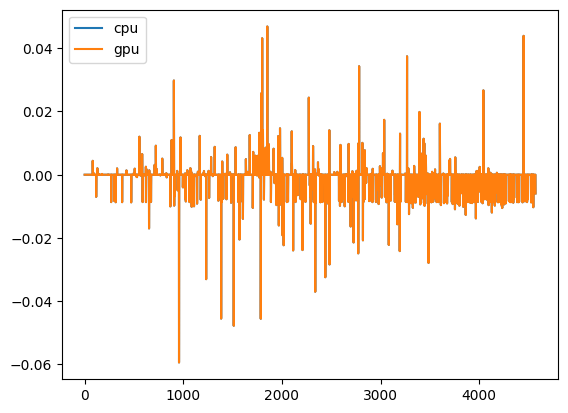

In [14]:
def verify(a, b, decimal, plot):
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal )

#! float32

verify(host_rez_w, d_rez_w.copy_to_host(), decimal=2, plot=True)

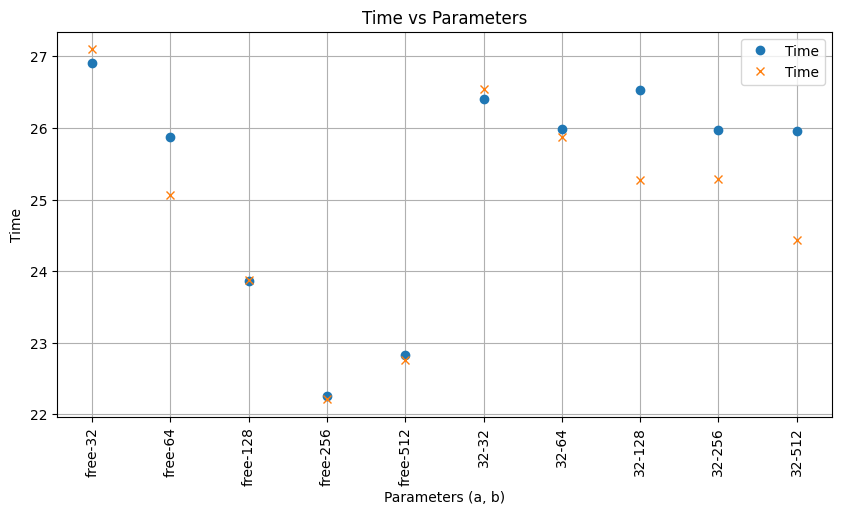